In [1]:
import numpy as np
import xarray as xr
import pandas as pd
# from dask.diagnostics import ProgressBar
from xgcm.grid import Grid
import xrft
import gsw
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline
# ProgressBar().register()

In [2]:
!pip install seawater

  Using cached seawater-3.3.4-py3-none-any.whl


# Load data

In [90]:
from intake import open_catalog
import xmitgcm.llcreader as llcreader
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/llc4320.yaml")

u = cat.LLC4320_SSU.to_dask()
v = cat.LLC4320_SSV.to_dask()
ssh = cat.LLC4320_SSH.to_dask()
ds = xr.merge([u, v,ssh])
ds = llcreader.llcmodel.faces_dataset_to_latlon(ds, metric_vector_pairs=[])

# reset_coords()则是将坐标变量转换为数据变量
coords = cat.LLC4320_grid.to_dask().reset_coords()
coords = llcreader.llcmodel.faces_dataset_to_latlon(coords)

In [91]:
aim_location = np.logical_and(np.logical_and(coords.XC>130, coords.XC<160 ), 
                           np.logical_and(coords.YC>15, coords.YC<45 ))
aim_location

<xarray.DataArray 'XC' (j: 12960, i: 17280)>
dask.array<logical_and, shape=(12960, 17280), dtype=bool, chunksize=(4320, 4320), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959

In [92]:
%%time
ds_sel = ds.where(aim_location, drop=True)

CPU times: user 1min 10s, sys: 22.8 s, total: 1min 33s
Wall time: 21.3 s


In [93]:
%%time
coords2 = coords.where(aim_location, drop=True)

CPU times: user 2min 36s, sys: 51.3 s, total: 3min 27s
Wall time: 38 s


In [94]:
ds_sel

<xarray.Dataset>
Dimensions:  (time: 9030, j: 1838, i_g: 17280, i: 1440, j_g: 12960, face: 13)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i_g      (i_g) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 8708 8709 8710 8711 8712 ... 10542 10543 10544 10545
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
  * i        (i) int64 8064 8065 8066 8067 8068 ... 9499 9500 9501 9502 9503
  * j_g      (j_g) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
Data variables:
    U        (time, j, i_g, i) float32 dask.array<chunksize=(1, 1838, 4320, 576), meta=np.ndarray>
    V        (time, j_g, i, j) float32 dask.array<chunksize=(1, 4320, 576, 1838), meta=np.ndarray>
    Eta      (time, j, i) float32 dask.array<chunksize=(1, 1838, 576), meta=np.ndarray>

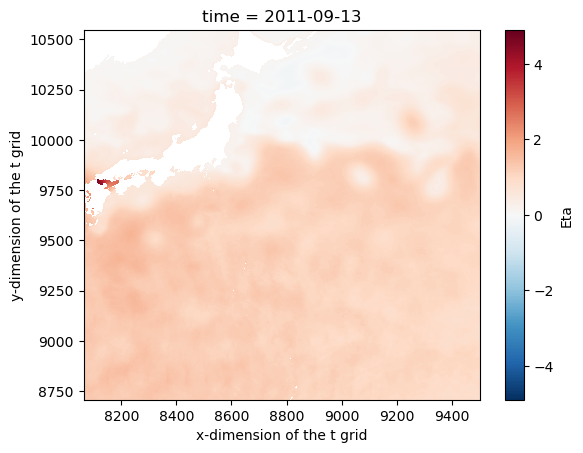

In [95]:
ds_sel.Eta.isel(time=0).plot()

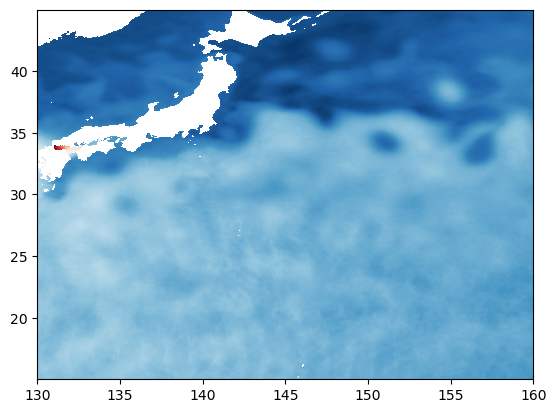

In [96]:
plt.pcolormesh(coords2.XC, coords2.YC,ds_sel.Eta.isel(time=0),cmap='RdBu_r')

In [97]:
i1 = ds_sel.i[0].values
i2 = ds_sel.i[-1].values+1
j1 = ds_sel.j[0].values
j2 = ds_sel.j[-1].values+1
i1,i2,j1,j2

(array(8064), 9504, array(8708), 10546)

In [98]:
dxC_sel = coords.dxC.isel(i_g=slice(i1, i2), j=slice(j1, j2))
dyG_sel = coords.dyG.isel(i_g=slice(i1, i2), j=slice(j1, j2))
dyC_sel = coords.dyC.isel(i=slice(i1, i2), j_g=slice(j1, j2))
dxG_sel = coords.dxG.isel(i=slice(i1, i2), j_g=slice(j1, j2))
XC_sel = coords.XC.isel(i=slice(i1, i2), j=slice(j1, j2))
YC_sel = coords.YC.isel(i=slice(i1, i2), j=slice(j1, j2))


In [99]:
llc_var = ds.sel(time=slice('2011-09-13','2012-09-13')).isel(time=slice(0,None,24),i_g=slice(i1, i2), j=slice(j1, j2),
                                                         i=slice(i1, i2), j_g=slice(j1, j2))
llc_var

<xarray.Dataset>
Dimensions:  (face: 13, i_g: 1440, j: 1838, time: 367, i: 1440, j_g: 1838)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i_g      (i_g) int64 8064 8065 8066 8067 8068 ... 9499 9500 9501 9502 9503
  * j        (j) int64 8708 8709 8710 8711 8712 ... 10542 10543 10544 10545
  * time     (time) datetime64[ns] 2011-09-13 2011-09-14 ... 2012-09-13
  * i        (i) int64 8064 8065 8066 8067 8068 ... 9499 9500 9501 9502 9503
  * j_g      (j_g) int64 8708 8709 8710 8711 8712 ... 10542 10543 10544 10545
Data variables:
    U        (time, j, i_g) float32 dask.array<chunksize=(1, 1838, 576), meta=np.ndarray>
    V        (time, j_g, i) float32 dask.array<chunksize=(1, 1838, 576), meta=np.ndarray>
    Eta      (time, j, i) float32 dask.array<chunksize=(1, 1838, 576), meta=np.ndarray>

In [100]:
llcw2 = xr.merge([llc_var,  dxC_sel, dyC_sel, dxG_sel,
                      dyG_sel,XC_sel, YC_sel,dyG_sel])
llcw2

<xarray.Dataset>
Dimensions:  (face: 13, i_g: 1440, j: 1838, time: 367, i: 1440, j_g: 1838)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i_g      (i_g) int64 8064 8065 8066 8067 8068 ... 9499 9500 9501 9502 9503
  * j        (j) int64 8708 8709 8710 8711 8712 ... 10542 10543 10544 10545
  * time     (time) datetime64[ns] 2011-09-13 2011-09-14 ... 2012-09-13
  * i        (i) int64 8064 8065 8066 8067 8068 ... 9499 9500 9501 9502 9503
  * j_g      (j_g) int64 8708 8709 8710 8711 8712 ... 10542 10543 10544 10545
Data variables:
    U        (time, j, i_g) float32 dask.array<chunksize=(1, 1838, 576), meta=np.ndarray>
    V        (time, j_g, i) float32 dask.array<chunksize=(1, 1838, 576), meta=np.ndarray>
    Eta      (time, j, i) float32 dask.array<chunksize=(1, 1838, 576), meta=np.ndarray>
    dxC      (j, i_g) float32 dask.array<chunksize=(1838, 576), meta=np.ndarray>
    dyC      (j_g, i) float32 dask.array<chunksize=(1838, 576), meta=np.ndarray>
    dxG      (j_g, i) float32 dask.array<chunksize=(1838, 576), meta=np.ndarray>
    dyG      (j, i_g) float32 dask.array<chunksize=(1838, 576), meta=np.ndarray>
    XC       (j, i) float32 dask.array<chunksize=(1838, 576), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(1838, 576), meta=np.ndarray>

In [101]:
metrics = {
    ('X',): ['dxC', 'dxG'], # X distances
    ('Y',): ['dyC', 'dyG'], # Y distances
#     ('Z',): ['drC'], # Z distances
    # ('X', 'Y'): ['rA', 'rAs', 'rAw'] # Areas
}


gridllc = Grid(llcw2, periodic=[],
               coords={
#                        'Z':{'center':'k','outer':'k_p1'},
                       'Y':{'center':'j','left':'j_g'},
                       'X':{'center':'i','left':'i_g'}},
               metrics=metrics
              )
gridllc

<xgcm.Grid>
Y Axis (not periodic, boundary=None):
  * center   j --> left
  * left     j_g --> center
X Axis (not periodic, boundary=None):
  * center   i --> left
  * left     i_g --> center

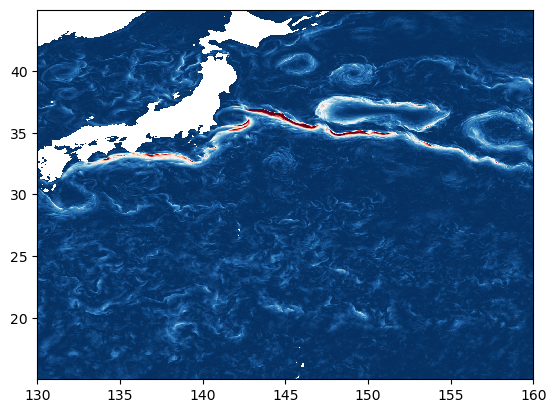

In [14]:
#  统一坐标轴之后，计算KE，坐标不一致无法计算。
tmp=.5*(gridllc.interp(llcw2.U.isel(time=0)**2,'X',boundary='extend')
                       + gridllc.interp(llcw2.V.isel(time=0)**2,'Y',boundary='extend')
                      )
plt.pcolormesh(llcw2.XC, llcw2.YC, tmp,cmap='RdBu_r', vmax=2, vmin=0, rasterized=True, shading='auto')

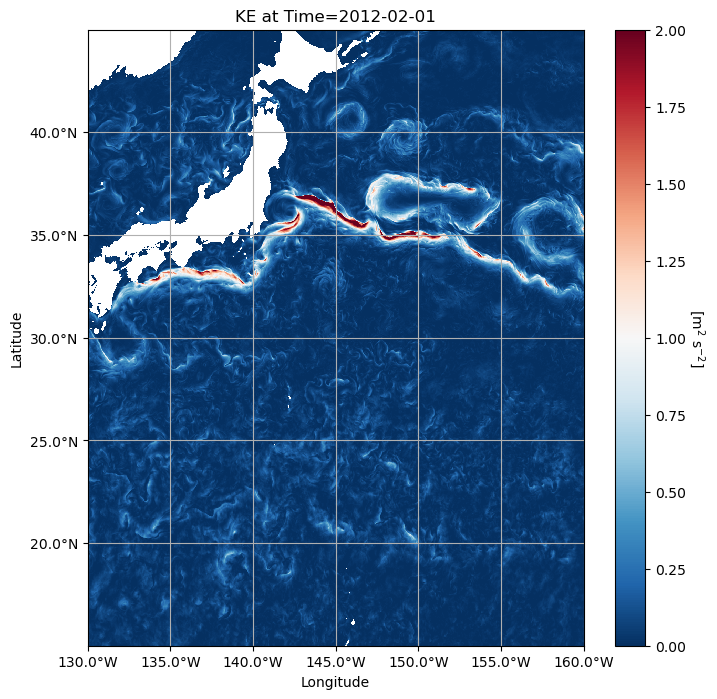

In [15]:
from matplotlib.ticker import FuncFormatter

def format_longitude(x, pos):
    return f"{x:.1f}°W"

def format_latitude(y, pos):
    return f"{y:.1f}°N"

plt.figure(figsize=(8, 8))
plt.pcolormesh(llcw2.XC, llcw2.YC,
              tmp,
               cmap='RdBu_r', vmax=2, vmin=0, rasterized=True, shading='auto')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('KE at Time=2012-02-01')

# 设置坐标轴刻度的格式
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_longitude))
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_latitude))

cbar = plt.colorbar()
cbar.set_label(r'[m$^2$ s$^{-2}$]', rotation=270, labelpad=15)
plt.grid(True)
plt.show()


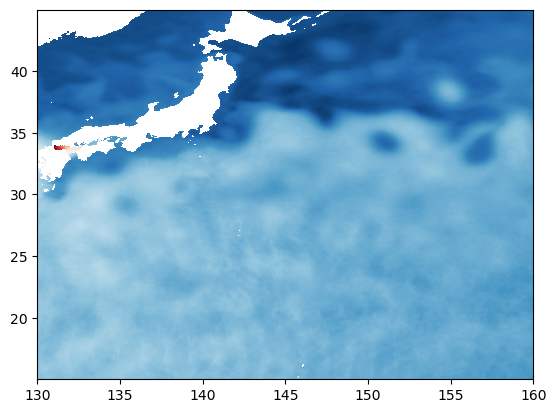

In [16]:
plt.pcolormesh(coords2.XC, coords2.YC,ds_sel.Eta.isel(time=0),cmap='RdBu_r')

In [17]:
# dxC_sel = coords.dxC.isel(i_g=slice(coords2.i.values[0], coords2.i.values[-1]+1), j=slice(coords2.j.values[0], coords2.j.values[-1]+1))
# dyG_sel = coords.dyG.isel(i_g=slice(coords2.i.values[0], coords2.i.values[-1]+1), j=slice(coords2.j.values[0], coords2.j.values[-1]+1))

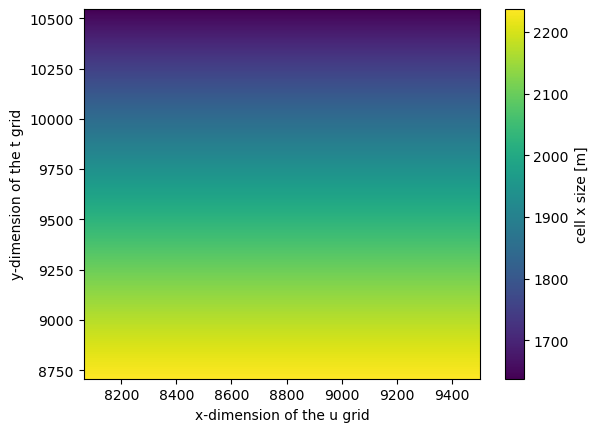

In [18]:
dxC_sel.plot()

In [19]:
mean_value_dx = dxC_sel.mean().values
mean_value_dy = dyG_sel.mean().values
mean_value_dx, mean_value_dy

(array(1967.7207, dtype=float32), array(1814.552, dtype=float32))

In [20]:
# llcw0 = ds_sel.sel(time=slice('2012-02-01','2012-04-30'))
# llcw0

In [21]:
# llcw2 = xr.merge([llcw0.Eta,  dxC_sel, dyG_sel, coords2.XC,coords2.YC])
# llcw2

In [22]:
def mean_notisnan(inmatrix, axis=None):
    a_zero = np.nan_to_num(inmatrix)  # 将 NaN 转为 0
    mask = np.isfinite(inmatrix).astype(int)  # 创建一个掩码，非 NaN 为 1，NaN 为 0
    
    nmtr = np.sum(a_zero, axis=axis)
    dnmr = np.sum(mask, axis=axis)
    
    outmatrix = np.zeros_like(nmtr, dtype=float)
    outmatrix[dnmr > 0] = nmtr[dnmr > 0] / dnmr[dnmr > 0]
    
    return outmatrix


# 测试函数
inmatrix = np.array([[np.nan, 2, 3], [4, np.nan, 6], [7, 8, 9]])
ave_dim = 1  # 沿着第一个维度计算平均值
result = mean_notisnan(inmatrix, ave_dim)
print("输出矩阵：")
print(result)

输出矩阵：
[2.5 5.  8. ]


In [23]:
import numpy as np

def handleNanValues(temhs, a):
    i, j = np.where(np.isnan(temhs))  # 找到所有NaN值的位置

    # 创建一个输出数组并初始化为输入数组的复制
    processedData = np.copy(temhs)

    for x, y in zip(i, j):
        # 处理第一种情况：x和y都小于等于20
        if x <= 20 and y <= 20:
            processedData[x, y] = mean_notisnan(mean_notisnan(temhs[x:x+a+1, y:y+a+1], axis=0))

        # 处理第二种情况：x大于20，y小于等于20
        elif x > 20 and y <= 20:
            processedData[x, y] = mean_notisnan(mean_notisnan(temhs[x-a:x+1, y:y+a+1], axis=0))

        # 处理第三种情况：x小于等于20，y大于20
        elif x <= 20 and y > 20:
            processedData[x, y] = mean_notisnan(mean_notisnan(temhs[x:x+a+1, y-a:y+1], axis=0))

        # 处理第四种情况：x和y都大于20
        else:
            processedData[x, y] = mean_notisnan(mean_notisnan(temhs[x-a:x+1, y-a:y+1], axis=0))

    return processedData

# 测试函数
temhs = np.array([[np.nan, 2, 3], [4, np.nan, 6], [7, 8, 9]])
result = handleNanValues(temhs, 1)
print("处理后的数据：")
print(result)


处理后的数据：
[[3.   2.   3.  ]
 [4.   7.75 6.  ]
 [7.   8.   9.  ]]


In [24]:
def wang_detrend(in_matrix):
    # 获取矩阵尺寸
    m, n = in_matrix.shape

    # 首先去掉一个区域的平均值
    mean_in = np.mean(in_matrix)
    in_matrix = in_matrix - mean_in
    
    # 创建坐标网格
    x0 = np.arange(1, m+1)
    y0 = np.arange(1, n+1)
    x, y = np.meshgrid(x0, y0)

    # 将输入矩阵转换为列向量
    tempin = in_matrix.ravel()
    X = x.ravel()
    Y = y.ravel()

    # 计算线性平面的系数
    C = np.column_stack((X, Y))
    D = np.linalg.lstsq(C, tempin, rcond=None)[0]
    linearin = D[0] * X + D[1] * Y

    # 去除线性平面
    out1 = tempin - linearin
    
    # 将输出转换回原始矩阵形状
    out = out1.reshape(m, n)

    return out

# 示例
in_matrix = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
out_matrix = wang_detrend(in_matrix)
print("输出矩阵：")
print(out_matrix)


输出矩阵：
[[-4.30769231 -2.46153846 -0.61538462]
 [-2.46153846 -0.61538462  1.23076923]
 [-0.61538462  1.23076923  3.07692308]]


In [25]:
import numpy as np
import scipy.fftpack as fft

def psi2flux2v(dx, dy, psi):
    nx, ny = psi.shape

    # Size of domain
    Lx = dx * nx
    Ly = dy * ny

    # Check if nx is odd or even
    if nx % 2 == 0:
        Nx = nx // 2
        wn_x = 2 * np.pi * np.hstack((np.arange(Nx + 1), np.arange(-(Nx - 1), 0))) / Lx
    else:
        Nx = (nx - 1) // 2
        wn_x = 2 * np.pi * np.hstack((np.arange(Nx + 1), -np.arange(Nx))) / Lx

    # Check if ny is odd or even
    if ny % 2 == 0:
        Ny = ny // 2
        wn_y = 2 * np.pi * np.hstack((np.arange(Ny + 1), np.arange(-(Ny - 1), 0))) / Ly
    else:
        Ny = (ny - 1) // 2
        wn_y = 2 * np.pi * np.hstack((np.arange(Ny + 1), -np.arange(Ny))) / Ly

    kx, ky = np.meshgrid(wn_x, wn_y)
    wvsq = kx * kx + ky * ky

    u = np.real(fft.ifft2(-1j * ky * fft.fft2(psi)))
    v = np.real(fft.ifft2(1j * kx * fft.fft2(psi)))
    q = np.real(fft.ifft2(-wvsq * fft.fft2(psi)))

    ddxq = np.real(fft.ifft2(1j * kx * fft.fft2(q)))
    ddyq = np.real(fft.ifft2(1j * ky * fft.fft2(q)))

    Jpsiq = u * ddxq + v * ddyq

    Tkxky = np.real(np.conj(fft.fft2(psi)) * fft.fft2(Jpsiq)) / (nx**2 * ny**2)

    wn_max = np.sqrt(np.max(wn_y)**2 + np.max(wn_x)**2) / np.sqrt(2)
    dk = min((2 * np.pi / Lx), (2 * np.pi / Ly))
    step_max = min(Nx, Ny) + 1

    flux = np.zeros(step_max)
    wn_step = np.zeros(step_max)

    for step in range(1, step_max + 1):
        k = dk * step
        index = np.where(wvsq >= k**2)
        flux[step - 1] = np.sum(Tkxky[index])
        wn_step[step - 1] = k
        # wn_step[step - 1] = k.item()
        # wn_step[step - 1] = k[0]  # 使用索引 0 获取 k 的值，将其作为标量存储在 wn_step 中



    T = -(flux[1:] - flux[:-1]) / dk
    wn_T = (wn_step[1:] + wn_step[:-1]) / 2
    wn_flux = wn_step

    return flux, wn_flux, T, wn_T, u, v, q

# 使用示例：
# 使用函数的示例
dx = 1.0
dy = 1.0
psi = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

flux, wn_flux, T, wn_T, u, v, q = psi2flux2v(dx, dy, psi)
print("Flux:", flux)
print("wn_flux:", wn_flux)
print("T:", T)
print("wn_T:", wn_T)
print("u:", u)
print("v:", v)
print("q:", q)

Flux: [9.86864911e-17 0.00000000e+00]
wn_flux: [2.0943951 4.1887902]
T: [4.71193286e-17]
wn_T: [3.14159265]
u: [[ 1.81379936  1.81379936  1.81379936]
 [-3.62759873 -3.62759873 -3.62759873]
 [ 1.81379936  1.81379936  1.81379936]]
v: [[-0.60459979  1.20919958 -0.60459979]
 [-0.60459979  1.20919958 -0.60459979]
 [-0.60459979  1.20919958 -0.60459979]]
q: [[ 8.77298169e+00  6.57973627e+00  4.38649084e+00]
 [ 2.19324542e+00 -8.88178420e-16 -2.19324542e+00]
 [-4.38649084e+00 -6.57973627e+00 -8.77298169e+00]]


In [26]:
import time
import gsw
import seawater as sw
import scipy
import warnings
import numpy as np
import xarray as xr

In [102]:
llcw2 = xr.merge([llc_var.Eta,  dxC_sel, dyG_sel,XC_sel, YC_sel])

size_in_MB = llcw2.nbytes / (1024 * 1024)
print(f"Dataset size: {size_in_MB} MB")

Dataset size: 3745.8163833618164 MB


In [133]:
%%time
llcw2.load()

CPU times: user 97 µs, sys: 33 µs, total: 130 µs
Wall time: 136 µs


<xarray.Dataset>
Dimensions:  (j: 1838, time: 367, i: 1440, i_g: 1440)
Coordinates:
  * j        (j) int64 8708 8709 8710 8711 8712 ... 10542 10543 10544 10545
  * time     (time) datetime64[ns] 2011-09-13 2011-09-14 ... 2012-09-13
  * i        (i) int64 8064 8065 8066 8067 8068 ... 9499 9500 9501 9502 9503
  * i_g      (i_g) int64 8064 8065 8066 8067 8068 ... 9499 9500 9501 9502 9503
Data variables:
    Eta      (time, j, i) float32 1.271 1.276 1.279 ... -0.04999 -0.04914
    dxC      (j, i_g) float32 2.237e+03 2.237e+03 ... 1.638e+03 1.638e+03
    dyG      (j, i_g) float32 2.06e+03 2.06e+03 2.06e+03 ... 1.528e+03 1.528e+03
    XC       (j, i) float32 130.0 130.0 130.1 130.1 ... 159.9 159.9 160.0 160.0
    YC       (j, i) float32 15.01 15.01 15.01 15.01 ... 44.99 44.99 44.99 44.99

In [340]:
llcw_test1 = llcw2.sel(time=slice('2011-9-01','2012-1-30'))
# llcw_test1 = llcw2
llcw_test1

<xarray.Dataset>
Dimensions:  (j: 1838, time: 140, i: 1440, i_g: 1440)
Coordinates:
  * j        (j) int64 8708 8709 8710 8711 8712 ... 10542 10543 10544 10545
  * time     (time) datetime64[ns] 2011-09-13 2011-09-14 ... 2012-01-30
  * i        (i) int64 8064 8065 8066 8067 8068 ... 9499 9500 9501 9502 9503
  * i_g      (i_g) int64 8064 8065 8066 8067 8068 ... 9499 9500 9501 9502 9503
Data variables:
    Eta      (time, j, i) float32 1.271 1.276 1.279 ... -0.2421 -0.2393 -0.2365
    dxC      (j, i_g) float32 2.237e+03 2.237e+03 ... 1.638e+03 1.638e+03
    dyG      (j, i_g) float32 2.06e+03 2.06e+03 2.06e+03 ... 1.528e+03 1.528e+03
    XC       (j, i) float32 130.0 130.0 130.1 130.1 ... 159.9 159.9 160.0 160.0
    YC       (j, i) float32 15.01 15.01 15.01 15.01 ... 44.99 44.99 44.99 44.99

In [341]:
size_in_MB = llcw_test1.nbytes / (1024 * 1024)
print(f"Dataset size: {size_in_MB} MB")

Dataset size: 1453.9237823486328 MB


In [342]:
# llcw_test1.to_netcdf("Eta.nc")

In [343]:
llcw_test1.load() # load数据，可以大幅提高速度。

<xarray.Dataset>
Dimensions:  (j: 1838, time: 140, i: 1440, i_g: 1440)
Coordinates:
  * j        (j) int64 8708 8709 8710 8711 8712 ... 10542 10543 10544 10545
  * time     (time) datetime64[ns] 2011-09-13 2011-09-14 ... 2012-01-30
  * i        (i) int64 8064 8065 8066 8067 8068 ... 9499 9500 9501 9502 9503
  * i_g      (i_g) int64 8064 8065 8066 8067 8068 ... 9499 9500 9501 9502 9503
Data variables:
    Eta      (time, j, i) float32 1.271 1.276 1.279 ... -0.2421 -0.2393 -0.2365
    dxC      (j, i_g) float32 2.237e+03 2.237e+03 ... 1.638e+03 1.638e+03
    dyG      (j, i_g) float32 2.06e+03 2.06e+03 2.06e+03 ... 1.528e+03 1.528e+03
    XC       (j, i) float32 130.0 130.0 130.1 130.1 ... 159.9 159.9 160.0 160.0
    YC       (j, i) float32 15.01 15.01 15.01 15.01 ... 44.99 44.99 44.99 44.99

In [344]:
from scipy.signal import hann
import numpy as np
from scipy import interpolate
import matplotlib.patches as patches

# 计算m和n的长度

inter = 48//1
ex = inter  # 另一个参数（用途未指定）
e = inter  # 另一个参数（用途未指定）

# 初始化窗口和物理参数
m0 = 48*2  # 144

# 创建周期性汉宁窗
w_han = np.hanning(m0)
C, D = np.meshgrid(w_han, w_han)


g = 9.8
a = 8  # 另一个参数（用途未指定）

number = llcw_test1.time.shape[0]

print("number:", number)

number: 140


In [345]:
# 找到最接近给定经纬度的数据点
lon_value = 150
lat_value = 30

XC = llcw_test1['XC']
YC = llcw_test1['YC']
distances = np.sqrt((XC - lon_value)**2 + (YC - lat_value)**2)
min_dist_index = distances.argmin(dim=["j", "i"])
j_nearest = min_dist_index['j'].values.item()
i_nearest = min_dist_index['i'].values.item()
j_nearest,i_nearest

(850, 959)

In [346]:
shape_of_dyG = llcw_test1.dyG.shape
# shape_half_j = shape_of_dyG[0] // 2
# shape_half_i = shape_of_dyG[1] // 2

shape_half_j = j_nearest
shape_half_i = i_nearest

# 从大方块中取小方块 两倍的m0
i1 = shape_half_i - m0  # 四个角点
i2 = shape_half_i + m0 +1
j1 = shape_half_j - m0
j2 = shape_half_j + m0 +1

half_sbox = m0 // 2  # 72

m = len(range(i1, i2 + 1, inter))
n = len(range(j1, j2 + 1, inter))
    
# Initialize result matrices
flux = np.nan * np.ones((m, n, m0 // 2 + 1))
wn_flux = np.nan * np.ones((m, n, m0 // 2 + 1))
wn_flux.shape

(5, 5, 49)

In [347]:
# tmp.load()

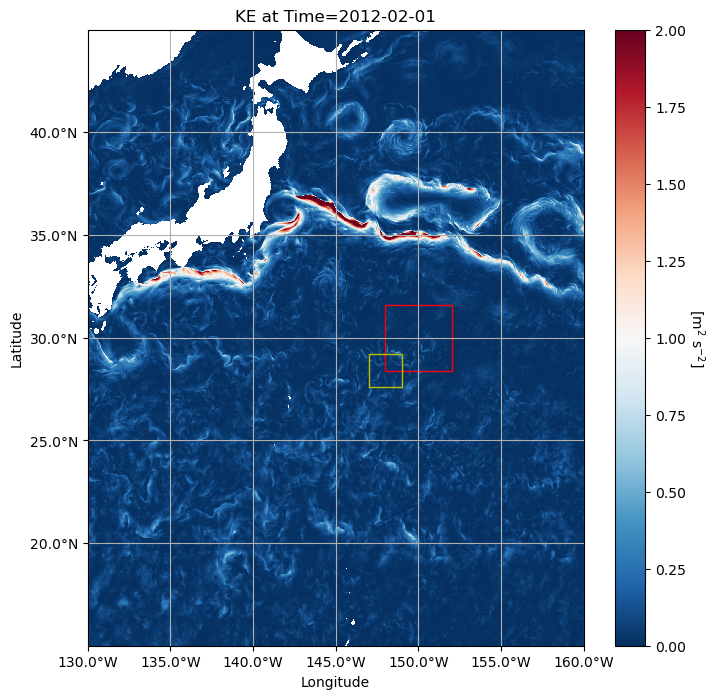

In [336]:
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Polygon

def format_longitude(x, pos):
    return f"{x:.1f}°W"

def format_latitude(y, pos):
    return f"{y:.1f}°N"

plt.figure(figsize=(8, 8))
plt.pcolormesh(llcw_test1.XC, llcw_test1.YC,
              tmp,
               cmap='RdBu_r', vmax=2, vmin=0, rasterized=True, shading='auto')


points = np.array([
    [llcw_test1.XC[j1, i1].values, llcw_test1.YC[j1, i1].values],
    [llcw_test1.XC[j2, i1].values, llcw_test1.YC[j2, i1].values],
    [llcw_test1.XC[j2, i2].values, llcw_test1.YC[j2, i2].values],
    [llcw_test1.XC[j1, i2].values, llcw_test1.YC[j1, i2].values]
])


polygon = Polygon(points, fill=None, edgecolor='r')
plt.gca().add_patch(polygon)


corner1_i, corner1_j = i1 - half_sbox, j1 - half_sbox
corner2_i, corner2_j = i1 - half_sbox, j1 + half_sbox
corner3_i, corner3_j = i1 + half_sbox, j1 + half_sbox
corner4_i, corner4_j = i1 + half_sbox, j1 - half_sbox

corner1 = [llcw_test1.XC[corner1_j, corner1_i].values, llcw_test1.YC[corner1_j, corner1_i].values]
corner2 = [llcw_test1.XC[corner2_j, corner2_i].values, llcw_test1.YC[corner2_j, corner2_i].values]
corner3 = [llcw_test1.XC[corner3_j, corner3_i].values, llcw_test1.YC[corner3_j, corner3_i].values]
corner4 = [llcw_test1.XC[corner4_j, corner4_i].values, llcw_test1.YC[corner4_j, corner4_i].values]
points = np.array([corner1, corner2, corner3, corner4])

polygon = Polygon(points, fill=None, edgecolor='y')
plt.gca().add_patch(polygon)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('KE at Time=2012-02-01')

# 设置坐标轴刻度的格式
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_longitude))
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_latitude))

cbar = plt.colorbar()
cbar.set_label(r'[m$^2$ s$^{-2}$]', rotation=270, labelpad=15)
plt.grid(True)
plt.show()


In [348]:
# Main loop to iterate through each NetCDF file
total_loops = (j2 - j1) // inter  # 计算总循环次数

remaining_loops = total_loops * number  # 初始化剩余循环次数

for k in range(1, number):
    ds0 = llcw_test1.isel(time=k)
    ssh = ds0['Eta']  
    shh = np.array(ssh)
    sh = shh
    print(f"Number: {number},Current k1: {k1}, Remaining loops: {remaining_loops}")
    for k1 in range(j1, j2 , inter):
        


        remaining_loops -= 1  # 每完成一次循环，剩余循环次数减1
        
        ff = sw.f(llcw_test1.YC.isel(j=k1,i=0))  # 根据纬度计算科氏参数。i向index取0即可。表示box中的中心纬度，取近似，代表区域。
        
        for k2 in range(i1, i2 , inter):          

            temhs = sh[k1 - half_sbox:k1 + half_sbox, k2 - half_sbox:k2 + half_sbox]

            dx = llcw_test1.dxC.isel(j=slice(k2 - half_sbox, k2 + half_sbox, None), i_g=slice(k1 - half_sbox, k1 + half_sbox, None)).mean().values
            dy = llcw_test1.dyG.isel(j=slice(k2 - half_sbox, k2 + half_sbox, None), i_g=slice(k1 - half_sbox, k1 + half_sbox, None)).mean().values


            rate = np.sum(np.isnan(temhs)) / (m0 * m0)        

            if rate <= 0.05:
                temhs = handleNanValues(temhs, a)
                temp2 = wang_detrend(temhs)
                temp3 = temp2 * C * D
                temp4 = temp3 * (g / ff)
                # fl, wn = psi2flux2v(dx, dy, temp4)
                fl, wn, *_ = psi2flux2v(dx, dy, temp4)


                flux[(k1 - j1) // ex, (k2 - i1) // e, :] = fl
                wn_squeezed = np.squeeze(wn)
                wn_flux[(k1 - j1) // ex, (k2 - i1) // e, :] = wn_squeezed

    scipy.io.savemat(f"./output/{k}.mat", {'flux': flux, 'wn_flux': wn_flux})

Number: 140,Current k1: 946, Remaining loops: 560
Number: 140,Current k1: 946, Remaining loops: 555
Number: 140,Current k1: 946, Remaining loops: 550
Number: 140,Current k1: 946, Remaining loops: 545
Number: 140,Current k1: 946, Remaining loops: 540
Number: 140,Current k1: 946, Remaining loops: 535
Number: 140,Current k1: 946, Remaining loops: 530
Number: 140,Current k1: 946, Remaining loops: 525
Number: 140,Current k1: 946, Remaining loops: 520
Number: 140,Current k1: 946, Remaining loops: 515
Number: 140,Current k1: 946, Remaining loops: 510
Number: 140,Current k1: 946, Remaining loops: 505
Number: 140,Current k1: 946, Remaining loops: 500
Number: 140,Current k1: 946, Remaining loops: 495
Number: 140,Current k1: 946, Remaining loops: 490
Number: 140,Current k1: 946, Remaining loops: 485
Number: 140,Current k1: 946, Remaining loops: 480
Number: 140,Current k1: 946, Remaining loops: 475
Number: 140,Current k1: 946, Remaining loops: 470
Number: 140,Current k1: 946, Remaining loops: 465


In [349]:
# 数据存储路径
bb = './output/'

# 获取结果矩阵的大小（以第一个文件为例）
file = bb + '1.mat'
data = scipy.io.loadmat(file)
flux = data['flux']  # 假设MAT文件中存储的变量名是'flux'
m1, m2, m3 = flux.shape

# 初始化累加矩阵
fluxa = np.zeros((m1, m2, m3))

fluxa.shape
# fluxa

(5, 5, 49)

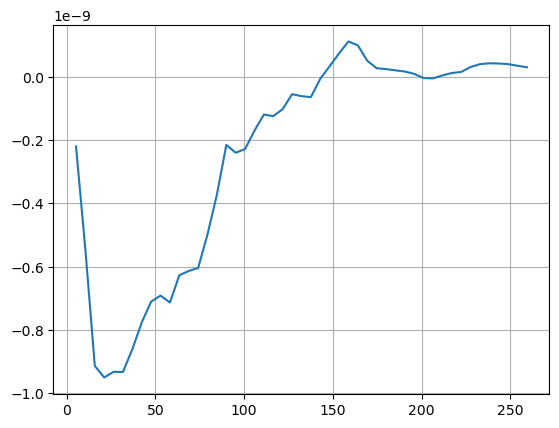

In [350]:
# 聚合所有的flux和wn_flux数据
# number = 10  # 请根据你的实际情况设置这个值
for k in range(1, number):
    file = bb + str(k) + '.mat'
    data = scipy.io.loadmat(file)
    flux = data['flux']  # 假设MAT文件中存储的变量名是'flux'
    fluxa += flux  # 累加flux

# 计算平均值
flux_a = fluxa / number
flux_b = np.nanmean(np.nanmean(flux_a, axis=1), axis=0)

# if np.isnan(flux_a).all():
#     flux_b = np.nan  # 或其他适当的值
# else:
#     flux_b = np.nanmean(np.nanmean(flux_a, axis=1), axis=0)

    
wn_flux = data['wn_flux']  # 假设最后一个MAT文件中存储的wn_flux可用
wn = np.nanmean(np.nanmean(wn_flux, axis=1), axis=0) * 1e6

# 绘制图像
plt.plot(wn / (2 * np.pi), flux_b)
plt.grid(True)
# plt.xticks(np.arange(0, 17, 1))
# plt.savefig('sample_plot.pdf')
plt.show()